## Random Forests (4 points (1+1+2))
Study the effect of the number of trees in a RandomForest on the EEG-eye-state dataset (http://www.openml.org/d/1471). This dataset measures brain activity using 15 sensors, and you need to predict whether the person's eyes are open or closed. 

* Train a RandomForest classifier on this dataset with an increasing number of trees (on a log scale as above). Plot the Out-Of-Bag error against the number of trees.
    - The Out-Of-Bag error is the test error obtained when using bootstrapping, and using the non-drawn data points as the test set. This is what a RandomForest does internally, so you can retrieve it from the classifier. The code below hints on how to do this.
* Construct the same plot, but now use 10-fold Cross-validation and error rate instead of the OOB error. Compare the two. What do you learn from this?
* Compare the performance of the RandomForest ensemble with that of a single full decision tree. Compute the AUC as well as the bias and variance. Does the bias and variance increase/decrease for the ensemble? Does the number of trees affect the result?

Hint: Error rate = 1 - accuracy. It is not a standard scoring metric for ```cross_val_score```, so you'll need to let it compute the accuracy values, and then compute the mean error rate yourself. 
Hint: We discussed bias-variance decomposition in class. It is not included in scikit-learn, so you'll need to implement it yourself. Always first calculate the bias and variance of each sample individually, and then sum them up.

In [1]:
%matplotlib inline
from preamble import *
plt.rcParams['savefig.dpi'] = 100
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# This is a temporary read-only OpenML key. Replace with your own key later. I replaced it with my own key
oml.config.apikey = '46c76cc89a9b46f9e43f3c4be1f2885e'

In [3]:
eeg = oml.datasets.get_dataset(1471) # Download Ionosphere data
X, y = eeg.get_data(target=eeg.default_target_attribute);

### Out Of Bag Error of Random Forest with increasing number of trees
The graph clearly shows that increasing the number of tree in the random forest decreases the Out-Of-Bag Error. This is the case especially at lower numbers of trees but at around 300 trees the model does not improve much anymore and since the computation time will increasingly take longer, we argue that you can stop at 300 trees. A lower Out of Bag Error means that the model is more precise in its predicted classifications. 

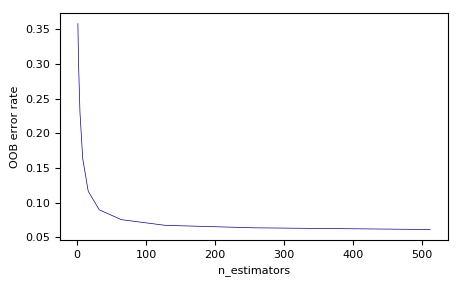

[0.35801068090787713, 0.29879839786381845, 0.23030707610146861, 0.16341789052069422, 0.11622162883845122, 0.089519359145527333, 0.075300400534045409, 0.067089452603471322, 0.063551401869158863, 0.061081441922563373]


In [36]:
# Out of bag errors can be retrieved from the RandomForest classifier. 
# You'll need to loop over the number of trees.
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
#from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from collections import OrderedDict

#Making empty list to store oob scores in for each tree-set
oob = []

ensemble_clfs = [
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True,
                               oob_score=True
                               ))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

#Amount of trees that are used in different forest
trees = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

for label, clf in ensemble_clfs:
    for i in trees:
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        oob.append(oob_error)

plt.plot(trees, oob)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.show()
print(oob);


### 10 fold Cross validation on Random Forest with increasing number of trees
The graph does not look very different from the graph obtained above. It has the same shape and the model does not improve anymore after around 300 trees. The difference is that the RandomForestClassifier with cross validation score method starts at the lower error rate than the normal RandomForestClassifier. This is probably due to the fact that the cross valication already is more robust at lower numbers of trees because this method test the data in 10 different ways for one tree already.

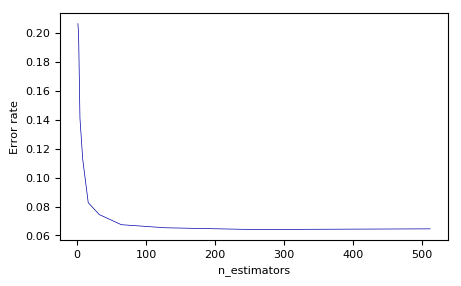

[0.20654205607476628, 0.19993324432576765, 0.14105473965287063, 0.11268357810413876, 0.082643524699599347, 0.074432576769025482, 0.067423230974632764, 0.065287049399198827, 0.064085447263017459, 0.064552736982643522]


In [35]:
from sklearn.model_selection import KFold #Import function to do stratified cross validation
from sklearn.model_selection import cross_val_score #Import CV function

#10 fold crossvaliadation
kfold = KFold(n_splits=10, shuffle=True, random_state=0)

#List to store error rate values
error = []

ensemble_clfs = [
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True,
                               oob_score=True
                               ))
]

#Amount of trees that are used in different forest
trees = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

for label, clf in ensemble_clfs:
    for i in trees:
        clf.set_params(n_estimators=i)
        clf.fit(X, y)
        score_list = cross_val_score(clf, X, y, cv=kfold)
        error_rate = 1 - (score_list.mean())

        #Put the error_rate in the list to plot later
        error.append(error_rate)

plt.plot(trees, error)
plt.xlabel("n_estimators")
plt.ylabel("Error rate")
plt.show()
print(error);

### Comparison accuracy and AUC on Tree Classifier and Random Forest
The Decision Tree has a accuracy of 0.836 on the test set while the Random Forest with 100 trees has a accuracy of 0.924 on the test set which indicates that the Random forest is better. The AUC is larger for the Random forest with 100 trees than for the Decision Tree, which also indicates that the Random Forest overal performs better. But it might be that the single Tree Classifier scores better at some point in the recall vs precision task, but overal Random Forest scores better. 
When there is only 1 tree in the Random Forest method, the Decision Tree has a higher AUC value, but already after 2 trees the Random Forest gets a higher AUC value and this increases the more trees are in the forest. It stabalizes again at around 200 trees.   

In [128]:
from sklearn.tree import DecisionTreeClassifier #Import normal Decision Tree classifier
from sklearn.metrics import roc_auc_score #Import Area under curve function
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import ShuffleSplit #Need this to do the shuffle

#Splitting data in training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

#Making normal decision tree
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy of one tree on training data: {:.3f}".format(tree.score(X_train, y_train)))
print("Accuracy of one tree on test data: {:.3f}".format(tree.score(X_test, y_test)))

#Making Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)
print("Accuracy of random forest on training data: {:.3f}".format(rf.score(X_train, y_train)))
print("Accuracy of random forest on test data: {:.3f}".format(rf.score(X_test, y_test)))

tree_auc = roc_auc_score(y_test, tree.predict_proba(X_test)[:, 1])
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1])
print("AUC for Decision Tree: {:.3f}".format(tree_auc))
print("AUC for Random Forest: {:.3f}".format(rf_auc));

Accuracy of one tree on training data: 1.000
Accuracy of one tree on test data: 0.836
Accuracy of random forest on training data: 1.000
Accuracy of random forest on test data: 0.924
AUC for Decision Tree: 0.833
AUC for Random Forest: 0.981


### Comparison bias and variance on Tree Classifier and Random Forest
The Tree Classifier method has a higher Bias value as well as a higher variance value than the Random Forest method.
Tree Classifier: Bias = 325.40 and Variance = 532.08
Random Forest: Bias =281.87 and Variance = 262.10
A high bias is most likely a indicator of underfitting while high varaince indicates overfitting. But since all values are very high it is hard to make sense out of it. But based on the numbers the Random Forest performs better than the Tree Classifier because it both underfits as overfits less.

In [107]:
# Bootstraps
n_repeat = 100
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)

rf_y_all_pred = [[] for _ in range(len(y))]
tree_y_all_pred = [[] for _ in range(len(y))]

# Random Forest
#Train classifier on each bootstrap and score predictions
for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
    # Train and predict
    rf.fit(X[train_index], y[train_index])
    rf_y_pred = rf.predict(X[test_index])
    
    # Store predictions
    for i,index in enumerate(test_index):
        rf_y_all_pred[index].append(rf_y_pred[i])     
        
        
        
# Compute bias, variance, error
rf_bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
            for i,x in enumerate(rf_y_all_pred)])
rf_var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
           for i,x in enumerate(rf_y_all_pred)])
rf_error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(rf_y_all_pred)])

# Tree Classifier
#Train classifier on each bootstrap and score predictions
for i, (train_index, test_index) in enumerate(shuffle_split.split(X)):
    # Train and predict
    tree.fit(X[train_index], y[train_index])
    tree_y_pred = tree.predict(X[test_index])
    
    # Store predictions
    for i,index in enumerate(test_index):
        tree_y_all_pred[index].append(tree_y_pred[i])
        
# Compute bias, variance, error
tree_bias_sq = sum([ (1 - x.count(y[i])/len(x))**2 * len(x)/n_repeat 
            for i,x in enumerate(tree_y_all_pred)])
tree_var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
           for i,x in enumerate(tree_y_all_pred)])
tree_error = sum([ (1 - x.count(y[i])/len(x)) * len(x)/n_repeat 
            for i,x in enumerate(tree_y_all_pred)])

print("Random Forest: Bias squared: %.2f, Variance: %.2f, Total error: %.2f" % (rf_bias_sq, rf_var, rf_error));
print("Tree Classifier: Bias squared: %.2f, Variance: %.2f, Total error: %.2f" % (tree_bias_sq, tree_var, tree_error));

Random Forest: Bias squared: 281.87, Variance: 262.10, Total error: 543.97
Tree Classifier: Bias squared: 325.40, Variance: 532.08, Total error: 857.48


### Effect of increasing number of trees on bias and variance on Random Forest
The plot shows the increase of bias and variance when the number of trees in the Random Forest increases. 
The high values and the fact that they are increasing do not make much sense, because this shows that the model starts to overfit and underfit extremely as more trees are considered. Strangely this graph shows that the more trees are taken incto account the more points are always classified wrongly as can be seen from the increasing bias value. Also the variance of the model increases which means that the more trees are made the more training data points are sometimes correct classified and sometimes incorrect classified. 


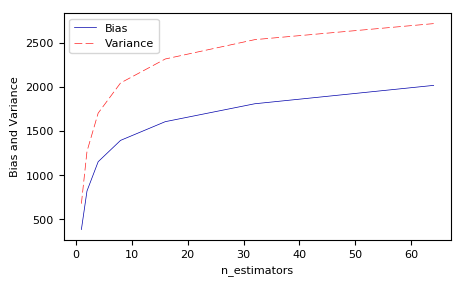

In [129]:
#Amount of trees that are used in different forest
trees = [1, 2, 4, 8, 16, 32, 64]

rf_y_all_pred = [[] for _ in range(len(y))]

n_repeat = 100
shuffle_split = ShuffleSplit(test_size=0.33, n_splits=n_repeat)

bias = []
variance = []

for label, clf in ensemble_clfs:
    for i in trees:
        rf.set_params(n_estimators=i)
        
        #Train classifier on each bootstrap and score predictions
        for j, (train_index, test_index) in enumerate(shuffle_split.split(X)):
            # Train and predict
            rf.fit(X[train_index], y[train_index])
            rf_y_pred = rf.predict(X[test_index])
    
            # Store predictions
            for j,index in enumerate(test_index):
                rf_y_all_pred[index].append(rf_y_pred[j])

        # Compute bias, variance, error
        rf_bias_sq = sum([ (1 - x.count(y[j])/len(x))**2 * len(x)/n_repeat 
                    for j,x in enumerate(rf_y_all_pred)])
        rf_var = sum([((1 - ((x.count(0)/len(x))**2 + (x.count(1)/len(x))**2))/2) * len(x)/n_repeat
                    for j,x in enumerate(rf_y_all_pred)])
        #rf_error = sum([ (1 - x.count(y[j])/len(x)) * len(x)/n_repeat 
            #for j,x in enumerate(rf_y_all_pred)])

        #Put the error_rate in the list to plot later
        bias.append(rf_bias_sq)
        variance.append(rf_var)

plt.plot(trees, bias, label="Bias")
plt.plot(trees, variance, label="Variance")
plt.legend(loc="best")
plt.xlabel("n_estimators")
plt.ylabel("Bias and Variance")
plt.show();